# 11장 - 심층 신경망 훈련

## 11.1 그래디언트 소실과 폭주 문제
#### 11.1.1 세이비어 초기화와 He 초기화
#### 11.1.2 수렴하지 않는 활성화 함수
#### 11.1.3 배치 정규화
#### 11.1.4 그래디언트 클리핑


## 11.2 미리 훈련된층 재사용하기
#### 11.2.1 텐서플로 모델 재사용하기
#### 11.2.2 다른 프레임워크의 모델 재사용하기
#### 11.2.3 신경망의 하위층 학습에서 제외하기
#### 11.2.4 동결된 층 캐싱하기
#### 11.2.5 상위층을 변경, 삭제, 대체하기
#### 11.2.6 모델 저장소
#### 11.2.7 비지도 사전훈련
#### 11.2.8 보조 작업으로 사전훈련

## 11.3 고속 옵티마이저
#### 11.3.1 모멘텀 최적화
#### 11.3.2 네스테로프 가속 경사
#### 11.3.3 AdaGrad
#### 11.3.4 RMSProp
#### 11.3.5 Adam 최적화
#### 11.3.6 학습률 스케줄링

## 11.4 과대적합을 피하기 위한 규제 방법
#### 11.4.1 조기종료
#### 11.4.2 l1과 l2 규제
#### 11.4.3 드롭아웃
#### 11.4.4 맥스-노름 규제
#### 11.4.5 데이터 증식

## 11.5 실용적 가이드라인
## 11.6 연습문제

----

In [ ]:
# %load_ext watermark
# %watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

In [5]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [6]:
import tensorflow as tf


----

## 11.1 그래디언트 소실과 폭주 문제


* 그래디언트 소실 : 출력층에서 입력층으로 역전파 알고리즘이 진행됨에 따라 그래디언트가 점점 작아져서 하위층(입력층)에 가까운 층들은 연결가중치가 거의 갱신되지 않는 것

![ooo](img_11_vanishing_gradient.jpg)

* 그래디언트 폭주 : 반대로 그래디언트가 점점 커져서 여러개의 층이 비정상적으로 큰 가중치로 갱신(발산)되는 것

* 2010년 Xavier Glorot과 Yoshua Bengio의  "Understandimg the Difficulty of Training Deep Feedforward Neural Networks" 논문
    - 로지스틱 시그모이드 활성화 함수 + 정규분포 가중치 초기화 사용 -> 각 층의 출력에서의 분산이 입력의 분산보다 더 커짐
    - 신경망의 위쪽(출력층)으로 갈수록 층을 지날때마다 분산이 계속 커져 높은층(출력층)에서는 활성화 함수가 0 또는 1로 수렴하게 됨
    - 시그모이드의 도함수는 f(1-f)이므로 함수의 값이 0 또는 1에 가까우면 도함수의 결과가 매우작아지고 층이 거듭될 수록 더 작아짐

In [7]:
def logit(z):
    return 1 / (1 + np.exp(-z))

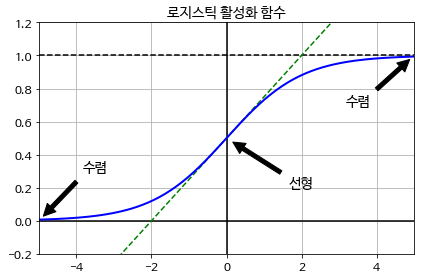

In [8]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('수렴', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('수렴', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('선형', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("로지스틱 활성화 함수", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

----

### 11.1.1 세이비어 초기화와 He 초기화

* 그래디언트 소실/발산을 완화하려면
    - 적절한 신호가 흐르기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다
    - 역방향에서 층을 통과하기 전과 후의 그래디언트 분산이 동일해야 한다

![ooo](img_11_bart.jpg)

* Xavier Glorot과 Yoshua Bengio의 가중치 초기화 방법
    - 출력의 분산은 입력 연결 수에 비례하여 늘어나므로 가중치의 분산을 1/n_inputs로 하여 입출력의 분산을 맞춘다
    - 역방향일 경우에는 입출력이 반대로 바뀌어 분산이 1/n_outputs가 되어야 한다
    - 두 방향에 대해 절충안으로 2/(n_inputs + n_outputs)를 가중치의 분산으로 한다
    - tf.contrib.layers에 구현됨
    - (세이비어 초기화 전략을 사용하면 훈련 속도를 상당히 높일 수 있다!)

![ooo](img_11_xavier_init.jpg)

In [ ]:
# tf의 xavier_initializer 모듈을 이용한 예시
W = tf.get_variable("W", shape=[784, 256], initializer=tf.contrib.layers.xavier_initializer())

* He 초기화
    - ReLU 활성화 함수 및 ELU 등의 변종들을 위한 초기화 전략

In [9]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
# tf.layers.dense는 기본적으로 세이비어 초기화함수를 사용하므로 아래와 같이 variance_scaling_initializer를 지정하여 He 초기화를 사용할 수 있다
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init, name="hidden1")

----

### 11.1.2 수렴하지 않는 활성화 함수

* 시그모이드 활성화 함수에 대한 오해
    - 생물학적 뉴런과 비슷하므로 최선의 선택일 것이라는 오해
    - 실제로는 ReLU가 더 잘 작동함


* 죽은 ReLU (dying ReLU) 문제
    - 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않음
    - 훈련 도중 가중치의 합이 음수가 되면 그 다음부턴 계속 0만 출력하게 됨


* Leaky ReLU
    - 하이퍼파라미터 alpha는 함수가 새는(leaky) 정도를 의미
    - 새는 정도는 x < 0 일 때의 기울기이며 일반적으로 0.01로 설정함
    - 작은 기울기가 leakyrelu를 절대 죽지 않게 만든다
    - 아래 기술할 다른 ReLU 변현들에 비해 속도가 빠르다
    - tf.nn.leaky_relu, tf.keras.layers.LeakyReLU 로 구현됨

![ooo](img_11_leaky_relu.png)

In [11]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

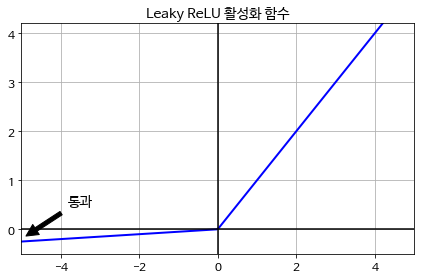

In [12]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('통과', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU 활성화 함수", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

* RReLU (randomized leaky ReLU)
    - 훈련 동안 주어진 범위 내에서 alpha를 무작위로 선택하고, 테스트 시에는 평균을 사용하는 방법
    - 신경망이 과대적합시 사용하기 좋음
 

* PReLU(parametric leaky ReLU)
    - alpha가 훈련 동안 학습되는 ReLU
    - alpha가 하이퍼파라미터가 아니라 역전파에 의해 갱신되므로, 훈련세트가 클 경우에 사용하기 좋음

* ELU (exponential linear unit)
    - 다른 모든 ReLU의 성능을 앞지르는 활성화 함수
    - alpha값은 x가 음수일 때 수렴할 값을 설정
    - x < 0일 떄, 음숫값이 들어오므로 평균 출력이 0에 더 가까워짐 -> 그래디언트 소실 완화
    - x < 0이어도 그래디언트가 0이 아니므로 죽은 ReLU 문제가 생기지 않음
    - alpha가 1이면 x = 0에서 연속적이므로 모든면에서 매끄러워서 경사하강법의 속도를 높여줌
    - 단, ReLU나 ReLU의 변종 함수들에 비해 계산이 느리다
    - tf.nn.elu, tf.keras.layers.ELU로 구현됨

![ooo](img_11_ELU.png)

![ooo](img_11_exp_func.png)

In [13]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

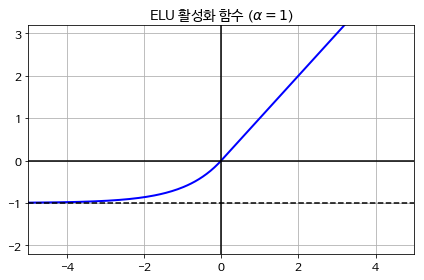

In [14]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU 활성화 함수 ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

텐서플로에서 ELU를 구현하는 것은 간단합니다. 층을 구성할 때 활성화 함수에 지정하기만 하면 됩니다:

In [25]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [26]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU

이 활성화 함수는 Günter Klambauer, Thomas Unterthiner, Andreas Mayr가 2017년에 쓴 [논문](https://arxiv.org/pdf/1706.02515.pdf)에서 소개되었습니다(나중에 책에 추가하겠습니다). 훈련할 때 SELU 활성화 함수를 사용한 완전 연결 신경망은 스스로 정규화를 합니다. 각 층의 출력은 훈련하는 동안 같은 평균과 분산을 유지하려는 경향이 있어 그래디언트 소실과 폭주 문제를 해결합니다. 이 활성화 함수는 심층 신경망에서 다른 활성화 함수보다 뛰어난 성능을 내므로 꼭 이 함수를 시도해봐야 합니다.

In [15]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

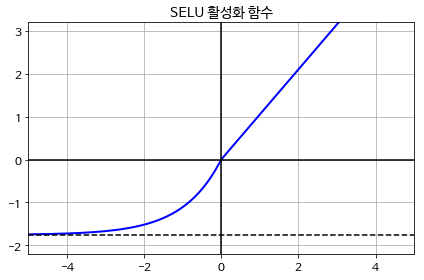

In [16]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU 활성화 함수", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

기본적으로 SELU 하이퍼파라미터(`scale`과 `alpha`)는 평균이 0, 표준 편차가 1에 가깝게 유지되도록 조정합니다(입력도 평균이 0, 표준 편차가 1로 표준화되었다고 가정합니다). 이 활성화 함수를 사용하면 100층으로 된 심층 신경망도 그래디언트 소실/폭주 문제없이 모든 층에서 대략 평균이 0이고 표준 편차가 1을 유지합니다:

In [29]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("층 {}: {:.2f} < 평균 < {:.2f}, {:.2f} < 표준 편차 < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

층 0: -0.26 < 평균 < 0.27, 0.74 < 표준 편차 < 1.27
층 10: -0.24 < 평균 < 0.27, 0.74 < 표준 편차 < 1.27
층 20: -0.17 < 평균 < 0.18, 0.74 < 표준 편차 < 1.24
층 30: -0.27 < 평균 < 0.24, 0.78 < 표준 편차 < 1.20
층 40: -0.38 < 평균 < 0.39, 0.74 < 표준 편차 < 1.25
층 50: -0.27 < 평균 < 0.31, 0.73 < 표준 편차 < 1.27
층 60: -0.26 < 평균 < 0.43, 0.74 < 표준 편차 < 1.35
층 70: -0.19 < 평균 < 0.21, 0.75 < 표준 편차 < 1.21
층 80: -0.18 < 평균 < 0.16, 0.72 < 표준 편차 < 1.19
층 90: -0.19 < 평균 < 0.16, 0.75 < 표준 편차 < 1.20


텐서플로 1.4 버전에 `tf.nn.selu()` 함수가 추가되었습니다. 이전 버전을 사용할 때는 다음 구현을 사용합니다:

In [30]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

하지만 SELU 활성화 함수는 일반적인 드롭아웃과 함께 사용할 수 없습니다(드롭아웃은 SELU 활성화 함수의 자동 정규화 기능을 없애버립니다). 다행히 같은 논문에 실린 알파 드롭아웃(Alpha Dropout)을 사용할 수 있습니다. 텐서플로 1.4에 `tf.contrib.nn.alpha_dropout()`이 추가되었습니다(Linz 대학교 생물정보학 연구소(Institute of Bioinformatics)의 Johannes Kepler가 만든 [구현](https://github.com/bioinf-jku/SNNs/blob/master/selu.py)을 확인해 보세요).

SELU 활성화 함수를 사용한 신경망을 만들어 MNIST 문제를 풀어 보겠습니다:

In [31]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

이제 훈련할 차례입니다. 입력을 평균 0, 표준 편차 1로 스케일 조정해야 합니다:

In [32]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 배치 데이터 정확도: 0.88 검증 세트 정확도: 0.923
5 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9574
10 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9664
15 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.9684
20 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9694
25 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9688
30 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9694
35 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.97


----

### 11.1.3 배치 정규화


* ELU 등 ReLU 응용 함수와 He 초기화를 사용하면 훈련 초기단계에서 그래디언트 소실/폭주를 크게 감소시킬 수 있지만, 훈련 중 다시 발생할 수 있다. 


* 내부 공변량 변화 문제
    - 훈련하는 동안 이전 층의 파라미터가 변함에 따라 각 층에 들어오는 입력의 분포가 변하는 문제

* 2015년 Sergey Ioffe, Christian Szegedy가 배치 정규화 (Batch Normalization, BN) 기법을 제안함

* 배치 정규화
    - 각 층에서 데이터의 분포를 정규화하는 기법
    - 입력 데이터의 평균이 0이 되도록 정규화 및 스케일링하고 이동시킴
    - 테스트 시에는 전체 훈련 세트의 평균과 표준편차를 대신 사용함
    - 배치 정규화가 적용된 모든 층은 gamma(스케일), beta(이동), mu(평균), sigma(표준편차) 총 4개의 파라미터를 학습하게 된다

![ooo](img_11_bn.png)

* 배치 정규화의 성능
    - 로지스틱 등 수렴되는 활성화 함수를 사용해도 소실 문제가 크게 감소됨
    - 네트워크가 가중치 초기화에 덜 민감해짐
    - 학습률을 크게 줄 수 있어 학습 속도가 개선됨
    - 배치 정규화가 규제 역할을 하므로 다른 규제 기법의 필요성이 줄어듦
    - "사람의 판단 능력을 뛰어 넘는 4.9%의 top-5 검증 에러를 달성함"

* 배치 정규화의 단점
    - 모델의 복잡도 증가
    - 실행 시간이 오래 걸림. 층마다 추가되는 계산으로 인해 신경망의 예측이 느려짐 -> 예측이 빨라야 하는 경우에 사용하기 어려움

* 텐서플로우 모듈
    - tf.nn.batch_normalization : 평균, 표준편차를 직접 계산해 입력해야하며, 스케일 조정과 이동을 위한 파라미터를 생성해야 함
    - tf.layers.batch_normalization : 모든 일을 대신 해주는 layer
    - tf.keras.layers.BatchNormalization : tf.keras 버전

각 은닉층의 활성화 함수 전에 배치 정규화를 추가하기 위해 ELU 활성화 함수를 배치 정규화 층 이후에 수동으로 적용하겠습니다.

노트: `tf.layers.dense()` 함수가 (책에서 사용하는) `tf.contrib.layers.arg_scope()`와 호환되지 않기 때문에 대신 파이썬의 `functools.partial()` 함수를 사용합니다. 이를 사용해 `tf.layers.dense()`에 필요한 매개변수가 자동으로 설정되도록 `my_dense_layer()`를 만듭니다(그렇지 않으면 `my_dense_layer()`를 호출할 때마다 덮어씌여질 것입니다). 다른 코드는 이전과 비슷합니다.

In [17]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)  # momentum 값은 이동평균 계산에 사용됨
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

같은 매개변수를 계속 반복해서 쓰지 않도록 파이썬의 `partial()` 함수를 사용합니다:

In [21]:
reset_graph()

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

In [22]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

각 층에 ELU 활성화 함수와 배치 정규화를 사용하여 MNIST를 위한 신경망을 만듭니다:

In [27]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

노트: 배치 정규화를 위해 별도의 업데이트 연산을 실행해 주어야 합니다(`sess.run([training_op, extra_update_ops],...`).

In [28]:
n_epochs = 20
batch_size = 200

In [30]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

11493376/11490434 [==============================] - 1s 0us/step


In [31]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [32]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.8952
1 검증 세트 정확도: 0.9202
2 검증 세트 정확도: 0.9318
3 검증 세트 정확도: 0.9422
4 검증 세트 정확도: 0.9468
5 검증 세트 정확도: 0.954
6 검증 세트 정확도: 0.9568
7 검증 세트 정확도: 0.96
8 검증 세트 정확도: 0.962
9 검증 세트 정확도: 0.9638
10 검증 세트 정확도: 0.9662
11 검증 세트 정확도: 0.9682
12 검증 세트 정확도: 0.9672
13 검증 세트 정확도: 0.9696
14 검증 세트 정확도: 0.9706
15 검증 세트 정확도: 0.9704
16 검증 세트 정확도: 0.9718
17 검증 세트 정확도: 0.9726
18 검증 세트 정확도: 0.9738
19 검증 세트 정확도: 0.9742


어!? MNIST 정확도가 좋지 않네요. 물론 훈련을 더 오래하면 정확도가 높아지겠지만 이런 얕은 신경망에서는 배치 정규화와 ELU가 큰 효과를 내지 못합니다. 대부분 심층 신경망에서 빛을 발합니다.

업데이트 연산에 의존하는 훈련 연산을 만들 수도 있습니다:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

이렇게 하면 훈련할 때 `training_op`만 평가하면 텐서플로가 업데이트 연산도 자동으로 실행할 것입니다:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

한가지 더, 훈련될 변수 개수가 전체 전역 변수 개수보다 적습니다. 이동 평균을 위한 변수는 훈련되는 변수가 아니기 때문입니다. 미리 학습한 신경망을 재사용할 경우(아래 참조) 이런 훈련되지 않는 변수를 놓쳐서는 안됩니다.

In [39]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [40]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

----

#### 11.1.4 그래디언트 클리핑


* 그래디언트 클리핑 (Gradient Clipping)
    - 역전파도리 때 일정 임계값을 넘어서지 못하게 그래디언트를 단순히 잘라내는 방법
    - 순환신경망(14장)에서 널리 사용되며 보통은 BN이 우선시된다
    - Optimizer의 minimize() 함수는 그래디언트 계산과 적용을 모두 수행하므로 compute_gradients(), clip_by_value(), apply_gradients() 세 개 함수로 분할하여 적용해야 한다

MNIST를 위한 간단한 신경망을 만들고 그래디언트 클리핑을 적용해 보겠습니다. 시작 부분은 이전과 동일합니다(학습한 모델을 재사용하는 예를 만들기 위해 몇 개의 층을 더 추가했습니다. 아래 참조):

In [33]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [34]:
learning_rate = 0.01

이제 그래디언트 클리핑을 적용합니다. 먼저 그래디언트를 구한 다음 `clip_by_value()` 함수를 사용해 클리핑하고 적용합니다:

In [35]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)  # 그래디언트를 -1.0 ~ 1.0 사이로 클리핑해서 적용한다 
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [41]:
grads_and_vars[0][0]

<tf.Tensor 'gradients/dnn/hidden1/MatMul_grad/tuple/control_dependency_1:0' shape=(784, 300) dtype=float32>

In [40]:
grads_and_vars[0][1]

<tf.Variable 'hidden1/kernel:0' shape=(784, 300) dtype=float32_ref>

나머지는 이전과 동일합니다:

In [36]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [37]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [38]:
n_epochs = 20
batch_size = 200

In [39]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.288
1 검증 세트 정확도: 0.7936
2 검증 세트 정확도: 0.8798
3 검증 세트 정확도: 0.906
4 검증 세트 정확도: 0.9164
5 검증 세트 정확도: 0.9218
6 검증 세트 정확도: 0.9296
7 검증 세트 정확도: 0.9358
8 검증 세트 정확도: 0.9382
9 검증 세트 정확도: 0.9414
10 검증 세트 정확도: 0.9456
11 검증 세트 정확도: 0.9474
12 검증 세트 정확도: 0.9478
13 검증 세트 정확도: 0.9534
14 검증 세트 정확도: 0.9568
15 검증 세트 정확도: 0.9566
16 검증 세트 정확도: 0.9574
17 검증 세트 정확도: 0.959
18 검증 세트 정확도: 0.9622
19 검증 세트 정확도: 0.9612


----

## 11.2 미리 훈련된 층 재사용하기

* 전이 학습 (transfer learning)
    - 큰 규모의 DNN을 처음부터 새로 훈련시키는 것은 좋지 못함
    - 비슷한 유형의 문제를 처리한 신경망을 찾아 하위층을 재사용하는 것이 훈련속도도 빠르고 필요한 학습 데이터도 적음

![ooo](img_11_transfer_learning.jpg)

----

### 11.2.1 텐서플로 모델 재사용하기

* 저장된 모델 로드하여 새로운 데이터셋으로 학습하기

먼저 그래프 구조를 로드해야 합니다. `import_meta_graph()` 함수가 그래프 연산들을 로드하여 기본 그래프에 적재하고 모델의 상태를 복원할 수 있도록 `Saver` 객체를 반환합니다. 기본적으로 `Saver` 객체는 `.meta` 확장자를 가진 파일에 그래프 구조를 저장하므로 이 파일을 로드해야 합니다:

In [45]:
reset_graph()

In [46]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

다음으로 훈련해야 할 모든 연산을 가져와야 합니다. 그래프 구조를 모를 때는 모든 연산을 출력해 볼 수 있습니다:

In [47]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

웁스, 연산이 엄청 많네요! 텐서보드로 그래프를 시각화해보는 것이 더 좋을 것 같습니다. 다음 코드는 주피터에서 그래프를 그려줍니다(만약 브라우저에서 보이지 않는다면 `FileWriter`로 그래프를 저장한 다음 텐서보드에서 열어 보세요):

In [ ]:
from tensorflow_graph_in_jupyter import show_graph

In [ ]:
show_graph(tf.get_default_graph())

필요한 연산을 찾았다면 그래프의 `get_operation_by_name()`이나 `get_tensor_by_name()` 메서드를 사용하여 추출할 수 있습니다:

In [50]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

원본 모델을 만들 때 다른 사람이 재사용하기 쉽게 연산에 명확한 이름을 부여하고 문서화를 하는 것이 좋습니다. 또 다른 방법은 처리해야 할 중요한 연산들을 모두 모아 놓은 컬렉션을 만드는 것입니다:

In [51]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

이렇게 하면 모델을 재사용할 때 다음과 같이 간단하게 쓸 수 있습니다:

In [52]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

이제 세션을 시작하고 모델을 복원하여 준비된 훈련 데이터로 훈련을 계속할 수 있습니다:

In [53]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # 모델 훈련 계속하기...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


실제로 테스트를 해보죠!

In [54]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9636
1 검증 세트 정확도: 0.9632
2 검증 세트 정확도: 0.9658
3 검증 세트 정확도: 0.9652
4 검증 세트 정확도: 0.9646
5 검증 세트 정확도: 0.965
6 검증 세트 정확도: 0.969
7 검증 세트 정확도: 0.9682
8 검증 세트 정확도: 0.9682
9 검증 세트 정확도: 0.9684
10 검증 세트 정확도: 0.9704
11 검증 세트 정확도: 0.971
12 검증 세트 정확도: 0.9668
13 검증 세트 정확도: 0.97
14 검증 세트 정확도: 0.9712
15 검증 세트 정확도: 0.9726
16 검증 세트 정확도: 0.9718
17 검증 세트 정확도: 0.971
18 검증 세트 정확도: 0.9712
19 검증 세트 정확도: 0.9712


* import_meta_graph() 없이 직접 코드로 그래프 구현

또 다른 방법으로 원본 그래프를 만든 파이썬 코드에 접근할 수 있다면 `import_meta_graph()` 대신 사용할 수 있습니다:

In [55]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

그 다음 훈련을 계속할 수 있습니다:

In [56]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9642
1 검증 세트 정확도: 0.9632
2 검증 세트 정확도: 0.9656
3 검증 세트 정확도: 0.9652
4 검증 세트 정확도: 0.9646
5 검증 세트 정확도: 0.9652
6 검증 세트 정확도: 0.9688
7 검증 세트 정확도: 0.9686
8 검증 세트 정확도: 0.9682
9 검증 세트 정확도: 0.9686
10 검증 세트 정확도: 0.9704
11 검증 세트 정확도: 0.9712
12 검증 세트 정확도: 0.967
13 검증 세트 정확도: 0.9698
14 검증 세트 정확도: 0.9708
15 검증 세트 정확도: 0.9724
16 검증 세트 정확도: 0.9718
17 검증 세트 정확도: 0.9712
18 검증 세트 정확도: 0.9708
19 검증 세트 정확도: 0.9712


* import한 그래프에 새로운 layer 추가하기

일반적으로 하위층만 재사용할 것입니다. `import_meta_graph()`를 사용하면 전체 그래프를 로드하지만 필요하지 않은 부분은 무시하면 됩니다. 이 예에서는 학습된 3번째 층 위에 4번째 은닉층을 새로 추가합니다(원래 4번째 층은 무시됩니다). 새로운 출력층도 추가하고 이 출력으로 손실을 계산하고 이를 최소화하기 위한 새로운 옵티마이저를 만듭니다. 전체 그래프(원본 그래프 전체와 새로운 연산)를 저장할 새로운 `Saver` 객체와 새로운 모든 변수를 초기화할 초기화 연산도 필요합니다:

In [60]:
reset_graph()

n_hidden4 = 20  # 새 층
n_outputs = 10  # 새 층

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

새로운 모델을 훈련시킵니다:

In [61]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9118
1 검증 세트 정확도: 0.9378
2 검증 세트 정확도: 0.9462
3 검증 세트 정확도: 0.9502
4 검증 세트 정확도: 0.9526
5 검증 세트 정확도: 0.9524
6 검증 세트 정확도: 0.9568
7 검증 세트 정확도: 0.96
8 검증 세트 정확도: 0.9612
9 검증 세트 정확도: 0.961
10 검증 세트 정확도: 0.9632
11 검증 세트 정확도: 0.9628
12 검증 세트 정확도: 0.965
13 검증 세트 정확도: 0.9654
14 검증 세트 정확도: 0.9666
15 검증 세트 정확도: 0.967
16 검증 세트 정확도: 0.9674
17 검증 세트 정확도: 0.9682
18 검증 세트 정확도: 0.9686
19 검증 세트 정확도: 0.9676


원본 모델을 만든 파이썬 코드에 접근할 수 있다면 필요한 부분만 재사용하고 나머지는 버릴 수 있습니다:

In [58]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

그러나 이전에 학습된 모델을 복원하기 위해 (복원할 변수 리스트를 전달합니다. 그렇지 않으면 그래프와 맞지 않는다고 에러를 낼 것입니다) `Saver` 객체를 하나 만들고 훈련이 끝난 후 새로운 모델을 저장하기 위해 또 다른 `Saver` 객체를 만들어야 합니다:

In [59]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                        # 책에는 없음
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # 책에는 없음
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})    # 책에는 없음
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # 책에는 없음
        print(epoch, "검증 세트 정확도:", accuracy_val)                      # 책에는 없음

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9024
1 검증 세트 정확도: 0.9332
2 검증 세트 정확도: 0.943
3 검증 세트 정확도: 0.947
4 검증 세트 정확도: 0.9516
5 검증 세트 정확도: 0.9532
6 검증 세트 정확도: 0.9558
7 검증 세트 정확도: 0.9592
8 검증 세트 정확도: 0.9586
9 검증 세트 정확도: 0.9608
10 검증 세트 정확도: 0.9626
11 검증 세트 정확도: 0.962
12 검증 세트 정확도: 0.964
13 검증 세트 정확도: 0.9662
14 검증 세트 정확도: 0.966
15 검증 세트 정확도: 0.9662
16 검증 세트 정확도: 0.9672
17 검증 세트 정확도: 0.9674
18 검증 세트 정확도: 0.9682
19 검증 세트 정확도: 0.9678


### 11.2.2 다른 프레임워크의 모델 재사용하기

이 예에서는 재사용하려는 각 변수에 대해 변수 초기화 할당 연산을 찾고, 초기화 될 값에 해당하는 두 번째 입력 핸들을 구합니다. 초기화가 실행될 때 여기에 `feed_dict` 매개변수를 사용하여 초깃값 대신 원하는 값을 주입합니다:

In [64]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [65]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # 다른 프레임워크로부터 가중치를 로드
original_b = [7., 8., 9.]                 # 다른 프레임워크로부터 편향을 로드

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] 모델의 나머지 부분을 구성

# hidden1 변수의 할당 노드에 대한 핸들을 구합니다
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] 새 작업에 모델을 훈련시킵니다
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # 책에는 없음

[[ 61.  83. 105.]]


또 다른 방법은 전용 할당 노드와 플레이스홀더를 만든는 것입니다. 이 방법은 더 번거롭고 효율적이지 않지만 하려는 방식이 잘 드러나는 방법입니다:

In [66]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # 다른 프레임워크로부터 가중치를 로드
original_b = [7., 8., 9.]                 # 다른 프레임워크로부터 편향을 로드

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] 모델의 나머지를 구성

# hidden1 변수의 할당 노드에 대한 핸들을 구합니다
with tf.variable_scope("", default_name="", reuse=True):  # 루트 범위
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# 전용 플레이스홀더와 할당 노드를 만듭니다
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] 새 작업에 모델을 훈련시킵니다
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


`get_collection()`에 `scope`를 지정하여 변수의 핸들을 가져올 수도 있습니다:

In [67]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

또는 그래프의 `get_tensor_by_name()` 메서드를 사용할 수 있습니다:

In [68]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [69]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### 11.2.3 하위층 동결하기

* Optimizer 변수목록에서 제외하기

Optimizer의 minimize() 함수를 실행할 때, var_list 파라미터에 동결할 층들을 제외하고 전달하는 방법


In [70]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [71]:
with tf.name_scope("train"):                                         # 책에는 없음
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # 책에는 없음
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [72]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [73]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.8962
1 검증 세트 정확도: 0.9288
2 검증 세트 정확도: 0.9402
3 검증 세트 정확도: 0.944
4 검증 세트 정확도: 0.9482
5 검증 세트 정확도: 0.9506
6 검증 세트 정확도: 0.9508
7 검증 세트 정확도: 0.9538
8 검증 세트 정확도: 0.9552
9 검증 세트 정확도: 0.9564
10 검증 세트 정확도: 0.9562
11 검증 세트 정확도: 0.9568
12 검증 세트 정확도: 0.9572
13 검증 세트 정확도: 0.9578
14 검증 세트 정확도: 0.9592
15 검증 세트 정확도: 0.9578
16 검증 세트 정확도: 0.9576
17 검증 세트 정확도: 0.9604
18 검증 세트 정확도: 0.9592
19 검증 세트 정확도: 0.9604


* tf.stop_gradient() 사용하기

tf.stop_gradient()가 적용된 아래의 모든 층이 고정됨


In [74]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [75]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # 동결층 재사용
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

In [76]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

훈련하는 코드는 이전과 완전히 동일합니다:

In [77]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.902
1 검증 세트 정확도: 0.931
2 검증 세트 정확도: 0.9434
3 검증 세트 정확도: 0.9476
4 검증 세트 정확도: 0.9516
5 검증 세트 정확도: 0.9524
6 검증 세트 정확도: 0.9524
7 검증 세트 정확도: 0.9558
8 검증 세트 정확도: 0.9554
9 검증 세트 정확도: 0.956
10 검증 세트 정확도: 0.9566
11 검증 세트 정확도: 0.9552
12 검증 세트 정확도: 0.9574
13 검증 세트 정확도: 0.9578
14 검증 세트 정확도: 0.958
15 검증 세트 정확도: 0.9572
16 검증 세트 정확도: 0.9564
17 검증 세트 정확도: 0.9578
18 검증 세트 정확도: 0.9592
19 검증 세트 정확도: 0.958


### 11.2.4 동결된 층 캐싱하기


In [78]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # 동결층 재사용 & 캐싱
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [79]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [80]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # 책에는 없음

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # 책에는 없음
                                                y: y_valid})             # 책에는 없음
        print(epoch, "검증 세트 정확도:", accuracy_val)                      # 책에는 없음

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.902
1 검증 세트 정확도: 0.931
2 검증 세트 정확도: 0.9434
3 검증 세트 정확도: 0.9476
4 검증 세트 정확도: 0.9516
5 검증 세트 정확도: 0.9524
6 검증 세트 정확도: 0.9524
7 검증 세트 정확도: 0.9558
8 검증 세트 정확도: 0.9554
9 검증 세트 정확도: 0.956
10 검증 세트 정확도: 0.9566
11 검증 세트 정확도: 0.9552
12 검증 세트 정확도: 0.9574
13 검증 세트 정확도: 0.9578
14 검증 세트 정확도: 0.958
15 검증 세트 정확도: 0.9572
16 검증 세트 정확도: 0.9564
17 검증 세트 정확도: 0.9578
18 검증 세트 정확도: 0.9592
19 검증 세트 정확도: 0.958


# 고속 옵티마이저

## 모멘텀 옵티마이저

In [81]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## 네스테로프 가속 경사

In [82]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

In [83]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

In [84]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam 최적화

In [85]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## 학습률 스케줄링

In [86]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [87]:
with tf.name_scope("train"):       # 책에는 없음
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [88]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [89]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9654
1 검증 세트 정확도: 0.9716
2 검증 세트 정확도: 0.9726
3 검증 세트 정확도: 0.9798
4 검증 세트 정확도: 0.9798


# 규제로 과대적합 피하기

## $\ell_1$과 $\ell_2$ 규제

$\ell_1$ 규제를 직접 구현해 보죠. 먼저 평상시처럼 모델을 만듭니다(간단하게 하기 위해 은닉층을 하나만 두겠습니다):

In [90]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

그다음, 층의 가중치에 대한 핸들을 얻어 크로스 엔트로피 손실에 $\ell_1$ 손실(즉, 가중치의 절댓값)을 더해 전체 손실을 계산합니다:

In [91]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 규제 하이퍼파라미터

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

나머지는 이전과 동일합니다:

In [92]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [93]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.831
1 검증 세트 정확도: 0.871
2 검증 세트 정확도: 0.8838
3 검증 세트 정확도: 0.8934
4 검증 세트 정확도: 0.8966
5 검증 세트 정확도: 0.8988
6 검증 세트 정확도: 0.9016
7 검증 세트 정확도: 0.9044
8 검증 세트 정확도: 0.9058
9 검증 세트 정확도: 0.906
10 검증 세트 정확도: 0.9068
11 검증 세트 정확도: 0.9054
12 검증 세트 정확도: 0.907
13 검증 세트 정확도: 0.9084
14 검증 세트 정확도: 0.9088
15 검증 세트 정확도: 0.9064
16 검증 세트 정확도: 0.9066
17 검증 세트 정확도: 0.9066
18 검증 세트 정확도: 0.9066
19 검증 세트 정확도: 0.9052


다른 방법으로는 `tf.layers.dense()` 함수에 규제 함수를 전달할 수 있습니다. 이 함수는 규제 손실을 계산하기 위한 연산을 만들고 규제 손실 컬렉션에 이 연산을 추가합니다. 모델 선언부는 이전과 동일합니다:

In [94]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

그다음, 동일한 매개변수를 매번 반복하지 않으려고 파이썬의 `partial()` 함수를 사용합니다. `kernel_regularizer` 매개변수를 지정해야 합니다:

In [95]:
scale = 0.001

In [96]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

기본 손실에 규제 손실을 추가합니다:

In [97]:
with tf.name_scope("loss"):                                     # 책에는 없음
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # 책에는 없음
        labels=y, logits=logits)                                # 책에는 없음
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # 책에는 없음
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

나머지는 평상시와 동일합니다:

In [98]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [99]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.8274
1 검증 세트 정확도: 0.8766
2 검증 세트 정확도: 0.8952
3 검증 세트 정확도: 0.9016
4 검증 세트 정확도: 0.908
5 검증 세트 정확도: 0.9096
6 검증 세트 정확도: 0.9124
7 검증 세트 정확도: 0.9154
8 검증 세트 정확도: 0.9178
9 검증 세트 정확도: 0.919
10 검증 세트 정확도: 0.92
11 검증 세트 정확도: 0.9224
12 검증 세트 정확도: 0.9212
13 검증 세트 정확도: 0.9228
14 검증 세트 정확도: 0.9222
15 검증 세트 정확도: 0.9218
16 검증 세트 정확도: 0.9218
17 검증 세트 정확도: 0.9228
18 검증 세트 정확도: 0.9216
19 검증 세트 정확도: 0.9214


## 드롭아웃

In [100]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [101]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [102]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [103]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9254
1 검증 세트 정확도: 0.9452
2 검증 세트 정확도: 0.9492
3 검증 세트 정확도: 0.9566
4 검증 세트 정확도: 0.9606
5 검증 세트 정확도: 0.9594
6 검증 세트 정확도: 0.9606
7 검증 세트 정확도: 0.9672
8 검증 세트 정확도: 0.969
9 검증 세트 정확도: 0.97
10 검증 세트 정확도: 0.9676
11 검증 세트 정확도: 0.968
12 검증 세트 정확도: 0.971
13 검증 세트 정확도: 0.9704
14 검증 세트 정확도: 0.972
15 검증 세트 정확도: 0.9702
16 검증 세트 정확도: 0.9728
17 검증 세트 정확도: 0.971
18 검증 세트 정확도: 0.9736
19 검증 세트 정확도: 0.9742


## 맥스 노름

2개의 은닉층을 가진 간단한 MNIST 신경망을 만들어 보겠습니다:

In [104]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

다음으로 첫 번째 은닉층의 가중치에 대한 핸들을 얻고 `clip_by_norm()` 함수를 사용해 가중치를 클리핑하는 연산을 만듭니다. 그런 다음 클리핑된 가중치를 가중치 변수에 할당하는 연산을 만듭니다:

In [105]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

두 번째 층에 대해서도 동일하게 할 수 있습니다:

In [106]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

초기와 연산과 `Saver` 객체를 만듭니다:

In [107]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

이제 모델을 훈련시킵니다. 이전과 매우 동일한데 `training_op`을 실행한 후에 `clip_weights`와 `clip_weights2` 연산을 실행하는 것만 다릅니다:

In [108]:
n_epochs = 20
batch_size = 50

In [109]:
with tf.Session() as sess:                                              # 책에는 없음
    init.run()                                                          # 책에는 없음
    for epoch in range(n_epochs):                                       # 책에는 없음
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):  # 책에는 없음
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # 책에는 없음
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # 책에는 없음
        print(epoch, "검증 세트 정확도:", accuracy_val)                     # 책에는 없음

    save_path = saver.save(sess, "./my_model_final.ckpt")               # 책에는 없음

0 검증 세트 정확도: 0.9568
1 검증 세트 정확도: 0.9696
2 검증 세트 정확도: 0.972
3 검증 세트 정확도: 0.977
4 검증 세트 정확도: 0.977
5 검증 세트 정확도: 0.977
6 검증 세트 정확도: 0.981
7 검증 세트 정확도: 0.9814
8 검증 세트 정확도: 0.9812
9 검증 세트 정확도: 0.9822
10 검증 세트 정확도: 0.9814
11 검증 세트 정확도: 0.985
12 검증 세트 정확도: 0.9822
13 검증 세트 정확도: 0.9842
14 검증 세트 정확도: 0.984
15 검증 세트 정확도: 0.9848
16 검증 세트 정확도: 0.984
17 검증 세트 정확도: 0.9838
18 검증 세트 정확도: 0.9842
19 검증 세트 정확도: 0.9844


위 구현은 이해하기 쉽고 잘 작동하지만 조금 번거롭습니다. 더 나은 방법은 `max_norm_regularizer()` 함수를 만드는 것입니다:

In [110]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # 규제 손실을 위한 항이 없습니다
    return max_norm

그런 다음 (필요한 임계값을 지정해서) 맥스 노름 규제 매개변수에 넘길 함수를 만들기 위해 이 함수를 호출합니다. 은닉층을 만들 때 이 규제 함수를 `kernel_regularizer` 매개변수를 통해 전달할 수 있습니다:

In [111]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [112]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [113]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

훈련 연산이 실행된 후에 가중치 클리핑 연산을 실행하는 것을 제외하면 이전과 동일합니다:

In [114]:
n_epochs = 20
batch_size = 50

In [115]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # 책에는 없음
        print(epoch, "검증 세트 정확도:", accuracy_val)                      # 책에는 없음

    save_path = saver.save(sess, "./my_model_final.ckpt")                # 책에는 없음

0 검증 세트 정확도: 0.9558
1 검증 세트 정확도: 0.9704
2 검증 세트 정확도: 0.9728
3 검증 세트 정확도: 0.9758
4 검증 세트 정확도: 0.9766
5 검증 세트 정확도: 0.9786
6 검증 세트 정확도: 0.9818
7 검증 세트 정확도: 0.9808
8 검증 세트 정확도: 0.9812
9 검증 세트 정확도: 0.981
10 검증 세트 정확도: 0.9816
11 검증 세트 정확도: 0.9824
12 검증 세트 정확도: 0.9804
13 검증 세트 정확도: 0.9822
14 검증 세트 정확도: 0.9822
15 검증 세트 정확도: 0.982
16 검증 세트 정확도: 0.9816
17 검증 세트 정확도: 0.9824
18 검증 세트 정확도: 0.9822
19 검증 세트 정확도: 0.9826


# 연습문제 해답

11장의 연습문제는 [11_deep_learning_exercise](11_deep_learning_exercises.ipynb) 노트북에 있습니다.